In [1]:
import numpy as np
import geometry
from matplotlib import pyplot as plt
from scipy.special import p_roots
from scipy.sparse.linalg import gmres

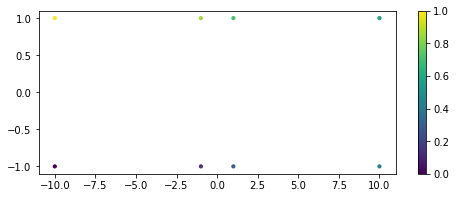

In [2]:
plt.figure(figsize=(8,3))

points = np.array([[-10,  -1], [-1,  -1], [1,  -1], [10,  -1],
                  [10,   1], [1,   1], [-1,   1], [-10,   1]])
plt.scatter(points[:,0], points[:,1], c=np.linspace(0,1,8),s=10)
plt.colorbar()

In [4]:
points = np.array([[-10,  -1], [-1,  -1], [1,  -1], [10,  -1],
                  [10,   1], [1,   1], [-1,   1], [-10,   1]])
gamma1 = geometry.line(points[0], points[1])
u1 = np.zeros(gamma1.x.shape)
v1 = np.zeros(gamma1.x.shape)
gamma2 = geometry.obstruction(scale=(2, 2), shift=(-1,-1))
u2 = np.zeros(gamma2.x.shape)
v2 = np.zeros(gamma2.x.shape)
gamma3 = geometry.line(points[2], points[3])
u3 = np.zeros(gamma3.x.shape)
v3 = np.zeros(gamma3.x.shape)
gamma4 = geometry.cap(rotate=-np.pi/2, shift=(points[3]+points[4])/2)
u4 = 1-gamma4.get_t().imag**2
v4 = np.zeros(gamma4.x.shape)
gamma5 = geometry.line(points[4], points[5])
u5 = np.zeros(gamma5.x.shape)
v5 = np.zeros(gamma5.x.shape)
gamma6 = geometry.obstruction(
    scale=(2, 2), shift=(1,1), rotate=np.pi)
u6 = np.zeros(gamma6.x.shape)
v6 = np.zeros(gamma6.x.shape)
gamma7 = geometry.line(points[6], points[7])
u7 = np.zeros(gamma7.x.shape)
v7 = np.zeros(gamma7.x.shape)
gamma8 = geometry.cap(rotate=np.pi/2, shift=(points[7]+points[0])/2)
u8 = 1-gamma8.get_t().imag**2
v8 = np.zeros(gamma8.x.shape)

Gamma = [gamma.get_data() for gamma in [gamma1, gamma2, gamma3,
                                        gamma4, gamma5, gamma6, gamma7, gamma8]]

a = np.concatenate(
    [gamma[0] + 2*i for i, gamma in zip(range(len(Gamma)), Gamma)])
da = np.concatenate([gamma[1] for gamma in Gamma])
t = np.concatenate([gamma[2] for gamma in Gamma])
dt_da = np.concatenate([gamma[3] for gamma in Gamma])
k = np.concatenate([gamma[4] for gamma in Gamma])
u = np.concatenate([u1, u2, u3, u4, u5, u6, u7, u8])
v = np.concatenate([v1, v2, v3, v4, v5, v6, v7, v8])

h2 = u
h1 = -v

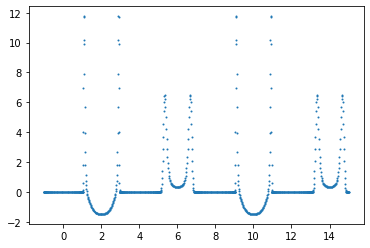

In [7]:
# plt.scatter(a,t.real,s=1)
# plt.scatter(a,t.imag,s=1)
plt.scatter(a,k,s=1)
# plt.scatter(a,(dt_da*da).real,s=1)
# plt.scatter(a,(dt_da*da).imag,s=1)

these are the plots for $\frac{dt}{da}$, where $a$ is the parameter and $t$ is the coordinates of the points on the curve. It's certainly does not look to be very smooth... But in theory it is smooth. 

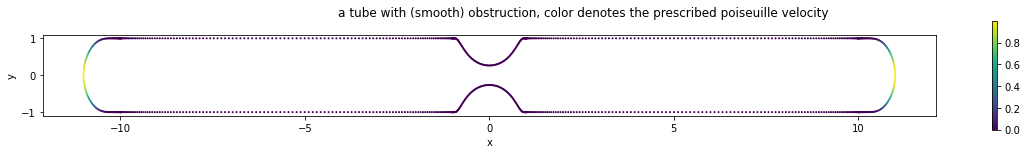

In [145]:
fig,ax = plt.subplots(figsize=(20,2))
cm = ax.scatter(t.real,t.imag, c=u,s=1)
ax.set_aspect('equal')
fig.colorbar(cm)
fig.suptitle('a tube with (smooth) obstruction, color denotes the prescribed poiseuille velocity')
ax.set_xlabel('x')
ax.set_ylabel('y')
print()

## solving the flow

In [146]:
def kernels(t,dt_da,da,curvature):
    dt = t[:,np.newaxis] - t[np.newaxis,:]
    d = (dt_da*da)[np.newaxis,:]
    
    # this ignore the error for computing the diagonal elements with 0/0 error
    with np.errstate(divide='ignore',invalid='ignore'):
        K1 = (1/np.pi*2j) * (-d/dt + np.conjugate(d/dt))
        K2 = (-1/np.pi*2j) * (-d/np.conjugate(dt) + np.conjugate(d)*dt/np.conjugate(dt)**2)
    # now we need to fill the diagonal elements
    d = dt_da*da
    K1_diagonal = curvature*np.abs(d)/(2*np.pi)
    K2_diagonal = -curvature*(d**2)/(np.abs(d)*2*np.pi)
    np.fill_diagonal(K1,K1_diagonal)
    np.fill_diagonal(K2,K2_diagonal)
    
    return K1,K2
K1,K2 = kernels(t,dt_da,da,k)

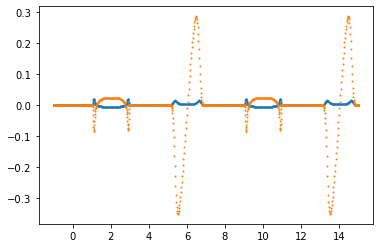

In [166]:
plt.scatter(a,K1.diagonal().real,s=1)
plt.scatter(a[1:],K1.diagonal(1).real,s=1)

In [147]:
n = len(t)

In [148]:
A = np.zeros((2*n,2*n))
A[:n,:n] = np.identity(n) + (K1+K2).real
A[:n,n:] = (-K1+K2).imag
A[n:,:n] = (K1+K2).imag
A[n:,n:] = np.identity(n) + (K1-K2).real

In [149]:
np.linalg.cond(A)

2496.7573501228476

In [150]:
rhs = np.concatenate((h1,h2))

In [151]:
omega,_ = gmres(A,rhs)
if _ == 0:
    print('solution converged')
else:
    print('solution did not converge')
omega = omega[:n] + 1j*omega[n:]

solution converged


In [136]:
def evaluation(z,omega,t,da ,dt_da):
    
    d_t = dt_da*da
    t_minus_z = t-z
    t_minus_z_square = t_minus_z**2
    
    phi = np.sum(omega*d_t/t_minus_z)/(2j*np.pi)
    d_phi = np.sum(omega*d_t/(t_minus_z**2))/(2j*np.pi)
    
    psi = (1/(2j*np.pi))*(
        2*np.sum(np.real(np.conjugate(omega)*d_t)/t_minus_z)
        - np.sum(np.conjugate(t)*omega*d_t/t_minus_z_square))
    
    dW = phi + z*np.conjugate(d_phi) + np.conjugate(psi)
    
    return dW

In [137]:
grid = np.array([(x,y) for x in np.linspace(-10.5,-1,1000) for y in np.linspace(-0.7,0.7,100)])
grid_x, grid_y = np.array(grid).T
grid_x = np.concatenate([grid_x,-grid_x])
grid_y = np.concatenate([grid_y,grid_y])
grid_z = grid_x + 1j*grid_y
grid_val = np.array([evaluation(z,omega,t,da,dt_da) for z in grid_z])
poiseuille_val = 1 - grid_y**2

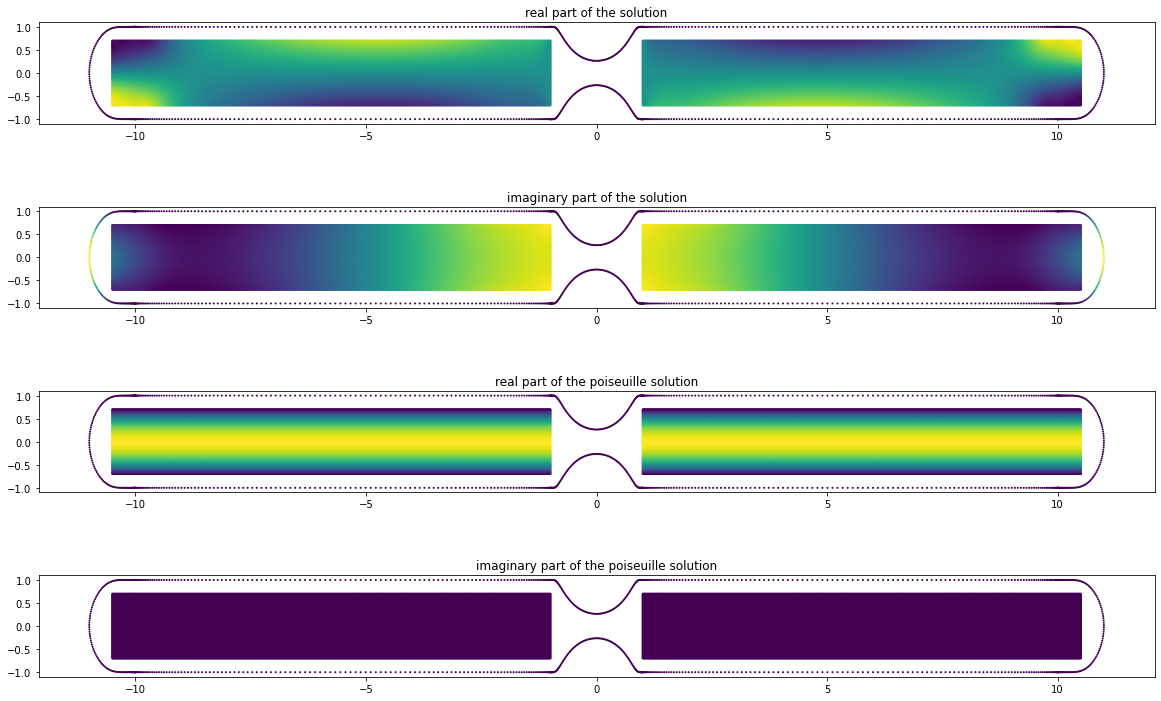

In [138]:
fig, axes = plt.subplots(4,1,figsize=(20,13))

axes[0].set_title('real part of the solution')
axes[0].scatter(t.real,t.imag, c=v,s=1)
axes[0].scatter(grid_x,grid_y,c=grid_val.real,s=1)
axes[0].set_aspect('equal')

axes[1].set_title('imaginary part of the solution')
axes[1].scatter(t.real,t.imag, c=u,s=1)
axes[1].scatter(grid_x,grid_y,c=grid_val.imag,s=1)
axes[1].set_aspect('equal')

axes[2].set_title('real part of the poiseuille solution')
axes[2].scatter(t.real,t.imag, c=v,s=1)
axes[2].scatter(grid_x,grid_y,c=poiseuille_val.real,s=1)
axes[2].set_aspect('equal')

axes[3].set_title('imaginary part of the poiseuille solution')
axes[3].scatter(t.real,t.imag, c=v,s=1)
axes[3].scatter(grid_x,grid_y,c=poiseuille_val.imag,s=1)
axes[3].set_aspect('equal')